In [1]:
import geemap, ee
import geopandas as gpd
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

Enter verification code: 4/1AWtgzh4_-RWo1SfmKSLDdvJN2w4lzHwF8JTsuG3xK6nnbTRWc_Yn9pGjyj0

Successfully saved authorization token.


### import shape file

In [2]:
import json
shp_path = "files/pakistan_shapefile/shape/Pakistan_Districts.shp"

# read shapefile into a geopands data frame and make sure it's initiated in the EPSG 4326 CRS
gdf = gpd.read_file(shp_path, crs='EPSG:4326')

# helper function to put the geodataframe in the right format for constructing an ee object
def shp_to_ee_fmt(geodf):
    data = json.loads(geodf.to_json())
    return data['features'][0]['geometry']['coordinates']

pakistan = ee.Geometry.MultiPolygon(shp_to_ee_fmt(gdf))

### clip shapefile to viirs-dnb 2018 composite

In [3]:
# get viirs-dnb and craete annual composite using avg_rad band
viirs2018 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2014-01-01','2014-12-31').select('avg_rad').median()

# clip it to pakistan shapefile
pak_viirs = viirs2018.clip(pakistan)

pakMap = geemap.Map()
# pakMap.add_basemap("SATELLITE")
pakMap.centerObject(pakistan, zoom=8)
pakMap.addLayer(pak_viirs, {'min':1, 'max':100}, 'VIIRS 2018', opacity=.75)
pakMap.addLayerControl()
pakMap



Map(center=[26.19347665169498, 65.38132276274891], controls=(WidgetControl(options=['position', 'transparent_b…

### compare with the rest of pakistan out of the shape area limitation:

In [4]:
# compare with the rest of pakistan out of the shape area limitation:
viirs2018Test = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate("2018-01-01","2018-12-31").select('avg_rad')
viirs2018Testmed = viirs2018Test.median()
lat = 31.140514
lon = 69.451642
wholeOfPakistanMap = geemap.Map(center=[lat,lon], zoom=8)
# wholeOfPakistanMap.add_basemap('SATELLITE')
wholeOfPakistanMap.addLayer(viirs2018Testmed, {'min':1, 'max':100}, 'VIIRS 2018', opacity=.75)
# wholeOfPakistanMap.addLayer(viirs2018Testmed.mask(viirs2018Testmed), {}, "VIIRS-DNB 2018 (monthly med)", opacity=.75)
wholeOfPakistanMap.addLayerControl()
wholeOfPakistanMap

Map(center=[31.140514, 69.451642], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox…

### Side by side comparision of DMSP-OLS satelite from 1996 to 2013, focused on shape file area

In [5]:
dmsp1996 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F101992")
dmsp2013 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F182013")
dmsp_split_map = geemap.Map()
dmsp_split_map.centerObject(pakistan, zoom=8)
# dmsp_split_map.add_basemap('SATELLITE')

dmsp1996_tile = geemap.ee_tile_layer(dmsp1996.mask(dmsp1996), {}, 'DMSP-OLS 1996', opacity=0.75)
dmsp2013_tile = geemap.ee_tile_layer(dmsp2013.mask(dmsp2013), {}, 'DMSP-OLS 2013', opacity=0.75)

dmsp_split_map.split_map(left_layer=dmsp1996_tile, right_layer=dmsp2013_tile)
dmsp_split_map

Map(center=[26.19347665169498, 65.38132276274891], controls=(ZoomControl(options=['position', 'zoom_in_text', …

#### notes: 
not too many changes over the years. Notables changes are around Awaran, Gajar, Ormara and a tiny portion of
the south east part of Hingol National Park


### Side by side comparision of VIIRS-DNB satelite from 2014 to 2020, focused on shape file area

In [6]:
viirs2014 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2014-01-01','2014-12-31').select('avg_rad').median()
viirs2020 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2020-01-01','2020-12-31').select('avg_rad').median()


viirs_split_map = geemap.Map()
viirs_split_map.centerObject(pakistan, zoom=8)
# viirs_split_map.add_basemap('SATELLITE')

viirs2014_tile = geemap.ee_tile_layer(viirs2014.mask(viirs2014), {}, 'VIIRS-ONB 2014', opacity=0.75)
viirs2020_tile = geemap.ee_tile_layer(viirs2020.mask(viirs2020), {}, 'VIIRS-ONB 2020', opacity=0.75)

viirs_split_map.split_map(left_layer=viirs2014_tile, right_layer=viirs2020_tile)
viirs_split_map



Map(center=[26.19347665169498, 65.38132276274891], controls=(ZoomControl(options=['position', 'zoom_in_text', …

notes:  in contrast to the DMSP data, few regions seem so have light after a few years. Only  Ormara and a tiny portion of
the south east part of Hingol National Park show signs of growth. Other regions appear dark in 2014 - this does 
not match the findings from the DMSP data where e.g. Awaran was lit up by 2013

but also these difference could be because we are using an average radian composite of montly images. QN: how were
the DMSP composires built? Is it okay for us to compare DMSP and VIIRS data?

> also note that DNB images for this region start from 2014 onwards (instead of 2012)

> QN: How can we focus on the aoi when using split_map?



## Combine and visualise DMSP OLS and VIIRS ONB
Define calibration method for DMSP, use it to calibrate all years from 1996 to 2013, convert each year to arrays?
how do we combine this with VIIRS?

Suggested approach is to create a time series of just the DMSP and then the VIIRS data
We can then megre these data and create another timeseries of the merged data. To ensure the merged timeseries
is accurate, we can compare with the two separate satelitte timeseries to see if they match up (like a concatenation)

### DMSP time series from 1996 to 2013

### VIIRS time series from 2014 to 2020
ref: https://worldbank.github.io/OpenNightLights/tutorials/mod4_1_time_series_charts.html

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 500 meter buffer around the POI (for now we'll use Jhal Jhao which seems central to out aoi. ToDo later we shall use polygon from shape files)
poiLat = 26.371142
poiLong = 65.167352
poi = ee.Geometry.Point(poiLat, poiLong).buffer(500)

viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2014-01-01','2020-5-31') #ToDo get whole year


def poi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi, scale=30).get('avg_rad')
    return img.set('date', img.date().format()).set('mean',mean)

poi_reduced_imgs = viirs.map(poi_mean)

nested_list = poi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])
df


,date,mean
0,2014-01-01T00:00:00,0.209964
1,2014-02-01T00:00:00,0.618782
2,2014-03-01T00:00:00,0.191974
3,2014-04-01T00:00:00,0.331794
4,2014-05-01T00:00:00,0.000000
...,...,...
72,2020-01-01T00:00:00,0.292586
73,2020-02-01T00:00:00,0.378035
74,2020-03-01T00:00:00,0.227209
75,2020-04-01T00:00:00,0.819306


In [8]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df

,mean
date,
2014-01-01,0.209964
2014-02-01,0.618782
2014-03-01,0.191974
2014-04-01,0.331794
2014-05-01,0.000000
...,...
2020-01-01,0.292586
2020-02-01,0.378035
2020-03-01,0.227209


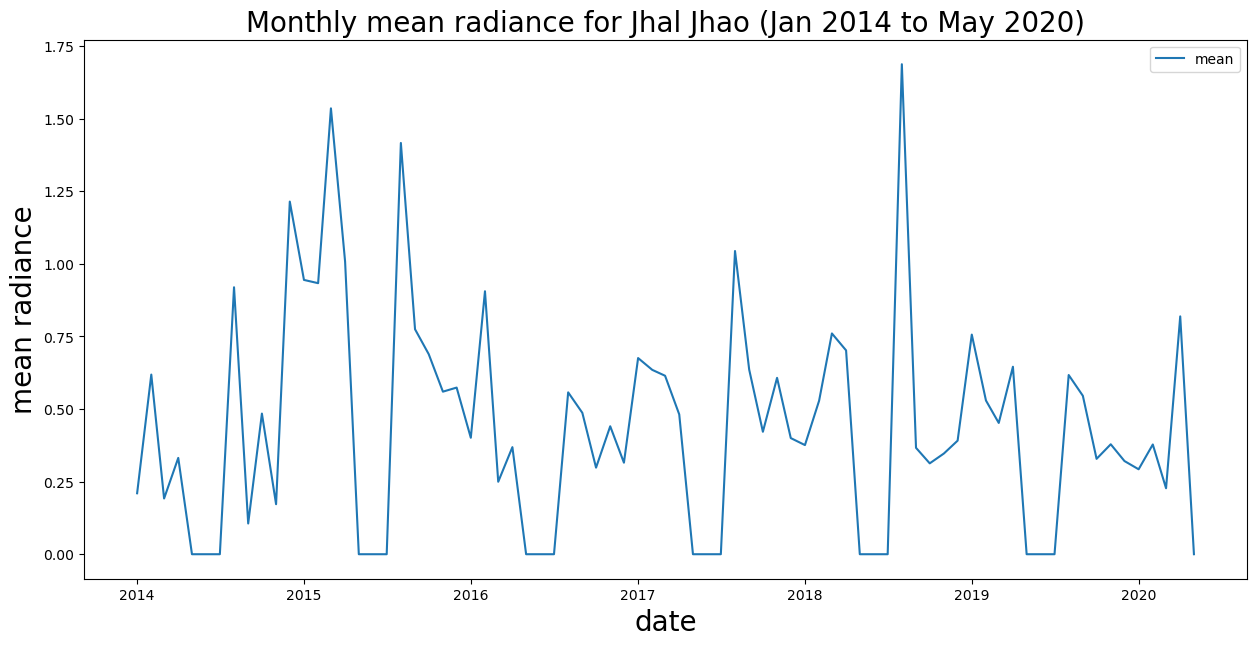

In [9]:
fig, ax = plt.subplots(figsize=(15,7))

sns.lineplot(data=df, ax=ax)

ax.set_ylabel('mean radiance',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title('Monthly mean radiance for Jhal Jhao (Jan 2014 to May 2020)',fontsize=20);

#### observations:
There are strong seasonal patterns which are odd for a residential area. There are also very low levels of mean 
radiance. For reference, a busy area such as the Seoul Stadium has radiance values ranging from 40 to 90.
> Do we need to scale down something to make the radiance values make sense for our ROI? Do we need to poke the poi_mean() function?

Smoothing out the data using a moving avg of 12 months to see overall trends:

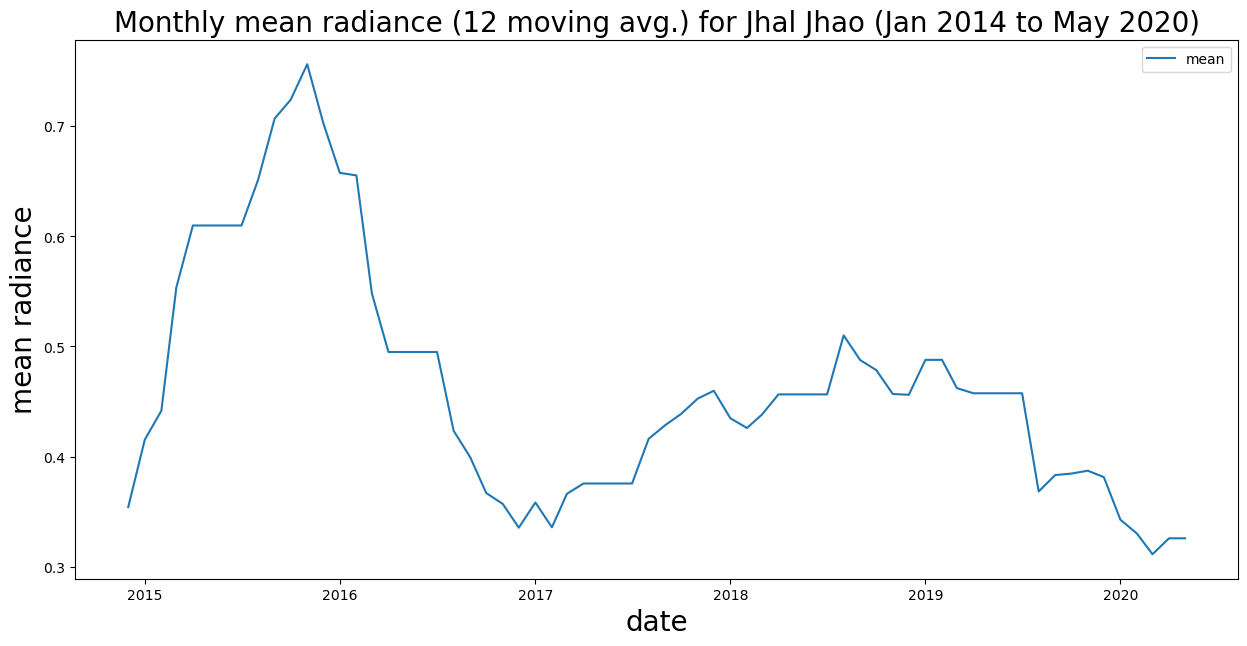

In [10]:
fig, ax = plt.subplots(figsize=(15,7))

window=12
sns.lineplot(data=df.rolling(window).mean(), ax=ax)

ax.set_ylabel('mean radiance',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title(f'Monthly mean radiance ({window} moving avg.) for Jhal Jhao (Jan 2014 to May 2020)',fontsize=20);



#### observations:
Smoothing out data shows an interesting spike of intensity in 2016. 
> Worth investigating what happened in 2016?
Let's see how the overall data looks once we combine with historical DMSP data.

Would also be inteseting to see why there was a general increase in 2019, then a resumption of the usual trend of 
dropping in light intensity

#### Sum of Lights analysis

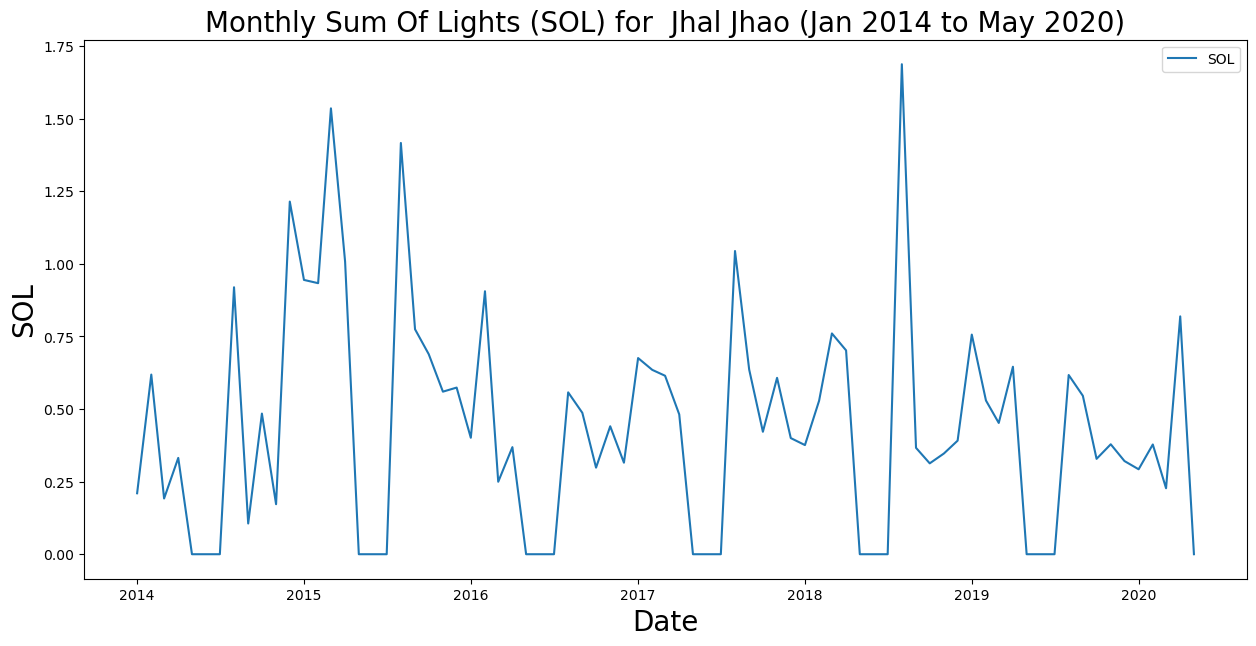

In [11]:
def poi_sol(img):
    sol = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi, scale=30, maxPixels=1e9).get('avg_rad')
    return img.set('date', img.date().format()).set('SOL',sol)

# > ToDo maybe change the scale and maxPixels? what determines these values? check documentation

# reduce collection
poi_reduced_imgs = viirs.map(poi_sol)
nested_list = poi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','SOL']).values().get(0)

sol_df = pd.DataFrame(nested_list.getInfo(), columns=['date','SOL'])
sol_df['date'] = pd.to_datetime(sol_df['date'])
sol_df = sol_df.set_index('date')

fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(data=sol_df, ax=ax)
ax.set_ylabel('SOL',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title('Monthly Sum Of Lights (SOL) for  Jhal Jhao (Jan 2014 to May 2020)',fontsize=20);

It's difficult to make out a trend in the monthly SOL. let's try smoothing out the data:


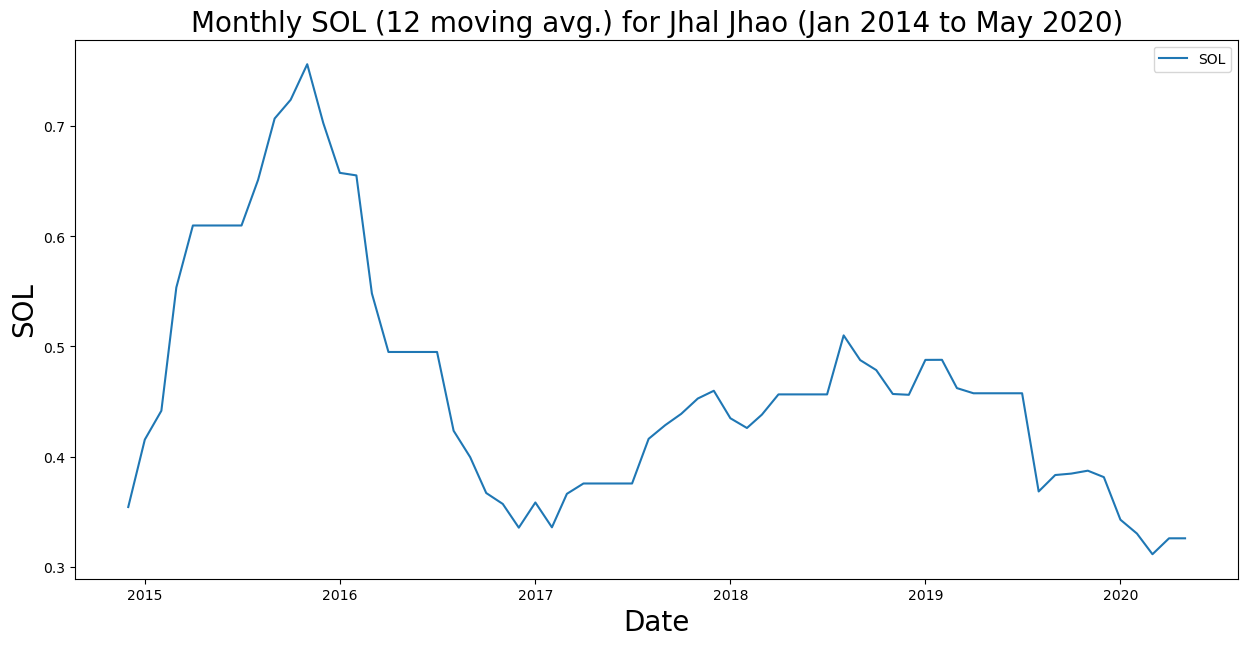

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
window=12
sns.lineplot(data=sol_df.rolling(window).mean(), ax=ax)
ax.set_ylabel('SOL',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title(f'Monthly SOL ({window} moving avg.) for Jhal Jhao (Jan 2014 to May 2020)',fontsize=20);

#### observations:
The smoothed out plot looks weirdly similar, if not the same, as the the smoothed out Montly mean radiance. 
Let's leave it at that and look into exploring data from DMSP using similar techniques as above

### DMSP time series from 1996 to 2013